Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [X] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Get MVP results
# Get League feature

In [0]:
import pandas as pd

df = pd.read_csv('MVP_1.csv')

In [9]:
df.Team.value_counts()

Yankees         494
Red Sox         490
- - -           488
White Sox       451
Tigers          443
Athletics       440
Cardinals       439
Indians         438
Giants          427
Cubs            424
Pirates         417
Dodgers         415
Braves          410
Phillies        401
Reds            386
Orioles         323
Twins           288
Angels          283
Royals          259
Astros          254
Rangers         246
Brewers         241
Mets            218
Blue Jays       217
Mariners        209
Padres          204
Senators        188
Expos           166
Marlins         127
Rockies         121
Browns          115
Diamondbacks     93
Nationals        64
Rays             56
Devil Rays       37
Redlegs          30
Bees             25
Colt .45's        9
Robins            5
Pilots            3
Name: Team, dtype: int64

In [0]:
teams = pd.read_csv('Team League.csv')

In [0]:
df = pd.merge(df, teams, on='Team')

In [0]:
winners = pd.read_csv('MVP Winners.csv')

In [0]:
winners.rename(columns={'Year' : 'Season'}, inplace=True)

In [0]:
winners.Season.fillna(value=1979, inplace=True)

In [58]:
winners.astype({'Season': 'int32'}).dtypes

Season       int32
Player      object
Position    object
MVP         object
dtype: object

In [0]:
winners.drop(columns=['Team', 'League'], inplace=True)

In [0]:
winners = winners[(winners.Position != 'RHP') & (winners.Position != 'LHP')]

In [0]:
df.rename(columns={'Name' : 'Player'}, inplace=True)

In [0]:
test = pd.merge(df, winners, on=['Season', 'Player'], how='outer')

In [72]:
test.head()

,Season,Player,Team,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,playerid,League,Position,MVP
0,1941,Ted Williams,Red Sox,143.0,456.0,606.0,185.0,112.0,33.0,3.0,37.0,135.0,120.0,147.0,NaN,27.0,3.0,NaN,0.0,10.0,2.0,4.0,0.406,1014040.0,American,NaN,NaN
1,1957,Ted Williams,Red Sox,132.0,420.0,546.0,163.0,96.0,28.0,1.0,38.0,96.0,87.0,119.0,33.0,43.0,5.0,2.0,0.0,11.0,0.0,1.0,0.388,1014040.0,American,NaN,NaN
2,2000,Nomar Garciaparra,Red Sox,140.0,529.0,599.0,197.0,122.0,51.0,3.0,21.0,104.0,96.0,61.0,20.0,50.0,2.0,7.0,0.0,8.0,5.0,2.0,0.372,190.0,American,NaN,NaN
3,1948,Ted Williams,Red Sox,137.0,509.0,638.0,188.0,116.0,44.0,3.0,25.0,124.0,127.0,126.0,NaN,41.0,3.0,NaN,0.0,10.0,4.0,0.0,0.369,1014040.0,American,NaN,NaN
4,1985,Wade Boggs,Red Sox,161.0,653.0,758.0,240.0,187.0,42.0,3.0,8.0,107.0,78.0,96.0,5.0,61.0,4.0,2.0,3.0,20.0,2.0,1.0,0.368,1001124.0,American,NaN,NaN


In [0]:
test.MVP.fillna(value='No', inplace=True)

In [0]:
df_ready = test.drop(columns=['Player', 'Team', 'Position', 'playerid'])

In [0]:
target = 'MVP'
features = df_ready.drop(columns=target).columns.tolist()

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np

train, val = train_test_split(df_ready, random_state=99)

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [0]:
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100)
)

In [93]:
pipeline.fit(X_train, y_train)
pipeline.score(X_val, y_val)

0.9872439118670274

In [94]:
df_ready.MVP.value_counts(normalize=True)

No     0.984922
Yes    0.015078
Name: MVP, dtype: float64

In [0]:
from xgboost import XGBRegressor

pipeline2 = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

In [110]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [0]:
train, val = train_test_split(train, random_state=99)

In [0]:
def clean(X):
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
   
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)

    generals = ['extraction_type_class', 'extraction_type_group',
                'waterpoint_type_group', 'source_type', 'source_class',
                'management']
    X = X.drop(columns=generals)

    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()

    return X

In [0]:
train = clean(train)
val = clean(val)

In [0]:
target = 'status_group'
features = train.drop(columns=target).columns.tolist()

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = clean(test)

In [116]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=99)
)

pipeline.fit(X_train, y_train)
val_score = pipeline.score(X_val, y_val)
print(f'Validation Score: {val_score:,.2%}')

Validation Score: 80.26%


In [122]:
example = X_val.iloc[[0]]

ex_pred = pipeline.predict(example)[0]
ex_pred

'functional needs repair'

In [0]:
feature = 'region_code'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

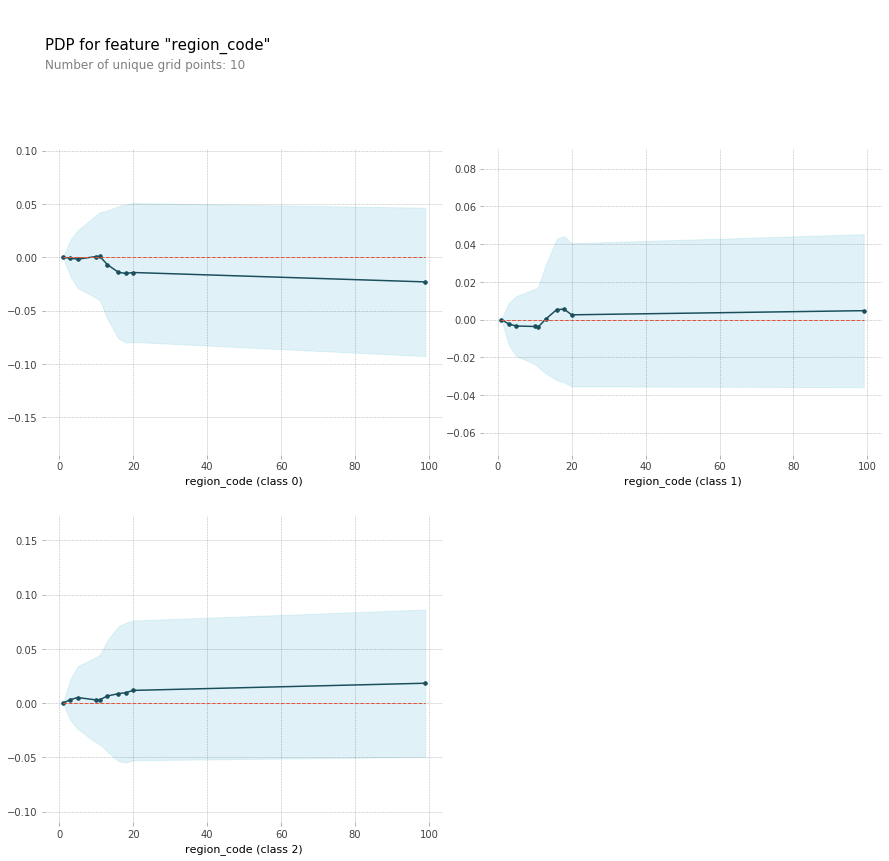

In [129]:
pdp_plot(isolated, feature_name=feature);